# Measuring Cache Sizes and Latency

Here's the CFiddle version of classic experiment to measure the size and latency of a system's caches.

In [1]:
from cfiddle import *


## Build A Randomize Circular Linked List

Here's the source:

In [2]:
exe = build("misses/misses.cpp", arg_map(OPTIMIZE="-O3"))
exe[0].source()

  0%|          | 0/1 [00:00<?, ?it/s]

#include"cfiddle.hpp"
#include<algorithm>
#include<vector>

struct MM {
    struct MM* next;  // Assume pointers are 8 bytes and 
                      // cache lines are 64.
    uint64_t junk[7]; // This forces the struct MM to take 
                      // a up a whole cache line, abolishing 
                      // spatial locality.
};


extern "C"
struct MM * miss(struct MM * start, uint64_t iterations) {
    // Here's the loop that does data-dependent misses.
    for(uint64_t i = 0; i < iterations; i++) { 
        start = start->next;
    }
    return start;
}


extern "C"
uint64_t go(int working_set, int iterations) {

    // All this effort is to build a circular linked list that 
    // winds through memory in an unpredictable order.
    unsigned int array_size = working_set/sizeof(MM);
    auto array = new struct MM[array_size];
    
    // This is clever part. 'index' is going to determine where 
    // the pointers go.  We fill it consecutive integers to start.
    std::vector<uint64_t> index;
    for(uint64_t i = 0; i < array_size; i++) {
        index.push_back(i);
    }
    
    // Then shuffle them...
    std::random_shuffle(index.begin(), index.end());

    // and convert them into pointers.
    for(uint64_t i = 0; i < array_size; i++) {
        array[index[i]].next = &array[index[(i + 1) % array_size]]; 
    } 

    MM * start = &array[0];

    start_measurement();
    start = miss(start, iterations);
    end_measurement();
    
    // Return garbage to foil the optimizer.
    return reinterpret_cast<uint64_t>(start); 
}

## Check The Assembly

As you can see, this loop in `miss()` can't get much shorter, and the `movq` is not dependent on anything but itself.  Since the `movq` will be the longest-latency instruction and the processor is out-of-order, the latency should be solely determined by the `movq` latency.

Having easy access to the assembly makes it easy to verify that our latency measurements will mean what we want them to.

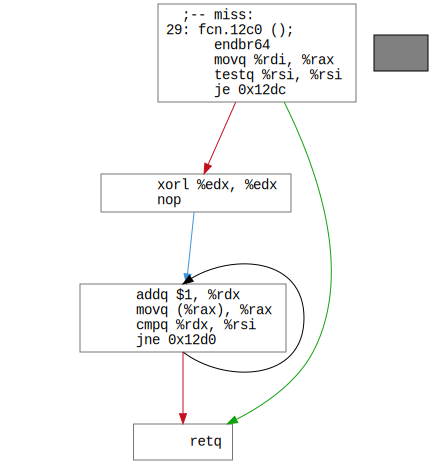

In [3]:
exe[0].cfg("miss")

## Measure Performance for Varying Working Set Sizes

In [4]:
results = run(exe, "go", arg_map(working_set=exp_range(1024, 1024*1024*4, 2**0.5), 
                                     iterations=100000000))
df = results.as_df()

  0%|          | 0/25 [00:00<?, ?it/s]

## Graph it!

<AxesSubplot:xlabel='working_set', ylabel='ns/access'>

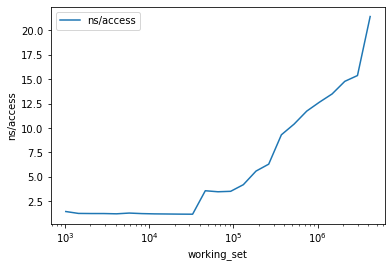

In [5]:
df['ns/access'] = df["ET"]/df["iterations"]*1e9
df.plot.line(y="ns/access", x="working_set", ylabel="ns/access", logx=True, logy=False)

## Measure In Cycles

If you performance counters work on your system, you can measure latency in cycles as well:

In [6]:
from cfiddle.perfcount import *
results = run(exe, "go", arg_map(working_set=exp_range(1024, 1024*1024*4, 2**0.5), 
                                     iterations=100000000),
                         perf_counters=["CYCLES"])
df = results.as_df()
df['cycles/access'] = df["CYCLES"]/df["iterations"]
df.plot.line(y="cycles/access", x="working_set", ylabel="cycles/access", logx=True, logy=False)

  0%|          | 0/25 [00:00<?, ?it/s]

KeyError: 'CYCLES'